# Final Model - GBR

## Imports

In [1]:
from pathlib import Path

import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

from utils import RAW_DATA_DIR, PROCESSED_DATA_DIR, print_metrics

pl.Config.set_tbl_rows(20)
set_config(transform_output = "pandas")

## Data loading

In [2]:
airports_df = pl.read_parquet(
    PROCESSED_DATA_DIR.joinpath('airports.parquet')
)

airports_df

airport_id,airport
u8,str
0,"""Airport17"""
1,"""Airport20"""
2,"""Airport26"""
3,"""Airport30"""
4,"""Airport31"""
5,"""Airport4"""
6,"""Airport43"""
7,"""Airport60"""


In [3]:
train_df = pl.read_parquet(
    PROCESSED_DATA_DIR.joinpath('training', 'train_full.parquet')
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""L2""",5242,2018-01-01,2017-11-27,846,35,0,4,2018-01-01 10:49:00,2018-01-01 12:14:00,85,-480,0,2,30,5,6659,212,3,4,0
"""OTH""",4790,2018-01-01,2017-11-27,937,35,0,4,2018-01-01 14:57:00,2018-01-01 16:17:00,80,-480,0,3,30,8,6659,316,3,4,0
"""OTH""",4837,2018-01-01,2017-11-27,281,35,0,6,2018-01-01 19:38:00,2018-01-01 20:43:00,65,-480,0,4,30,7,6659,316,4,3,0
"""L2""",5314,2018-01-01,2017-11-27,403,35,0,6,2018-01-01 19:05:00,2018-01-01 20:17:00,72,-480,0,4,30,7,6659,213,4,3,0
"""OTH""",6187,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 20:30:00,2018-01-01 21:58:00,88,-480,0,5,21,5,6579,354,7,3,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1
"""L3""",15130,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 16:53:00,2018-01-01 18:19:00,86,-480,0,4,30,7,6659,231,3,4,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0
"""L1""",6316,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 12:31:00,2018-01-01 15:55:00,204,-300,0,3,5,2,1468,360,1,5,0


In [4]:
test_df = pl.read_parquet(
    PROCESSED_DATA_DIR.joinpath('test', 'test_full.parquet')
)

test_df

carrier,flt_num,flt_departure_dt,observation_date,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""L2""",7465,2019-01-01,2018-11-27,35,0,9,2019-01-01 08:04:00,2019-01-01 10:49:00,165,-360,0,2,7,2,null,null,5,6,0
"""L2""",7067,2019-01-01,2018-11-27,35,0,9,2019-01-01 13:17:00,2019-01-01 16:00:00,163,-360,0,3,7,2,null,null,5,6,0
"""L2""",1232,2019-01-01,2018-11-27,35,0,9,2019-01-01 18:40:00,2019-01-01 21:25:00,165,-360,0,4,7,2,null,null,5,6,0
"""U3""",752,2019-01-01,2018-11-27,35,0,7,2019-01-01 08:45:00,2019-01-01 10:07:00,82,-360,0,2,9,3,null,null,5,0,0
"""L1""",5135,2019-01-01,2018-11-27,35,0,7,2019-01-01 07:25:00,2019-01-01 08:42:00,77,-360,0,1,9,2,null,null,5,0,0
"""L1""",10966,2019-01-01,2018-11-27,35,0,7,2019-01-01 11:54:00,2019-01-01 13:18:00,84,-360,0,2,9,3,null,null,5,0,0
"""L1""",2181,2019-01-01,2018-11-27,35,0,7,2019-01-01 15:34:00,2019-01-01 16:51:00,77,-360,0,3,9,2,null,null,5,0,0
"""L1""",2724,2019-01-01,2018-11-27,35,0,8,2019-01-01 06:00:00,2019-01-01 10:30:00,270,-360,0,1,5,2,null,null,5,1,0
"""L3""",18075,2019-01-01,2018-11-27,35,0,4,2019-01-01 15:10:00,2019-01-01 16:30:00,80,-480,0,3,32,9,null,null,3,4,0


In [5]:
raw_test_df = pl.read_parquet(
    RAW_DATA_DIR.joinpath('test', 'test_fares_data.parquet')
)

raw_test_df

,origin,destination,carrier,flt_num,flt_departure_dt,observation_date,origin_city,destination_city
i64,str,str,str,i64,str,str,str,str
1,"""Airport4""","""Airport43""","""L2""",7465,"""1/1/2019""","""11/27/2018""","""City4""","""City39"""
2,"""Airport4""","""Airport43""","""L2""",7067,"""1/1/2019""","""11/27/2018""","""City4""","""City39"""
3,"""Airport4""","""Airport43""","""L2""",1232,"""1/1/2019""","""11/27/2018""","""City4""","""City39"""
4,"""Airport43""","""Airport4""","""L1""",17783,"""1/3/2019""","""11/29/2018""","""City39""","""City4"""
5,"""Airport43""","""Airport4""","""L1""",5823,"""1/3/2019""","""11/29/2018""","""City39""","""City4"""
6,"""Airport43""","""Airport4""","""L1""",1763,"""1/3/2019""","""11/29/2018""","""City39""","""City4"""
7,"""Airport4""","""Airport17""","""U3""",752,"""1/1/2019""","""11/30/2018""","""City4""","""City17"""
8,"""Airport4""","""Airport17""","""U3""",752,"""1/2/2019""","""11/30/2018""","""City4""","""City17"""
9,"""Airport4""","""Airport17""","""U3""",752,"""1/3/2019""","""11/30/2018""","""City4""","""City17"""


In [6]:
full_data = train_df.vstack(
    test_df.with_columns(
        pl.lit(0).cast(pl.Int64()).alias('total_fare')
    ).select(
        train_df.columns
    )
)
full_data

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""L2""",5242,2018-01-01,2017-11-27,846,35,0,4,2018-01-01 10:49:00,2018-01-01 12:14:00,85,-480,0,2,30,5,6659,212,3,4,0
"""OTH""",4790,2018-01-01,2017-11-27,937,35,0,4,2018-01-01 14:57:00,2018-01-01 16:17:00,80,-480,0,3,30,8,6659,316,3,4,0
"""OTH""",4837,2018-01-01,2017-11-27,281,35,0,6,2018-01-01 19:38:00,2018-01-01 20:43:00,65,-480,0,4,30,7,6659,316,4,3,0
"""L2""",5314,2018-01-01,2017-11-27,403,35,0,6,2018-01-01 19:05:00,2018-01-01 20:17:00,72,-480,0,4,30,7,6659,213,4,3,0
"""OTH""",6187,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 20:30:00,2018-01-01 21:58:00,88,-480,0,5,21,5,6579,354,7,3,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1
"""L3""",15130,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 16:53:00,2018-01-01 18:19:00,86,-480,0,4,30,7,6659,231,3,4,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0
"""L1""",6316,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 12:31:00,2018-01-01 15:55:00,204,-300,0,3,5,2,1468,360,1,5,0


## Data processing

### Fare rescaling

#### Check if any (`route`, `carrier`) pair is missing in `train_df`

In [7]:
train_df.group_by('route_id', 'carrier').len().drop('len').join(
    test_df.group_by('route_id', 'carrier').len().drop('len'),
    on = ['route_id', 'carrier'],
    how = 'outer'
).null_count()

route_id,carrier,route_id_right,carrier_right
u32,u32,u32,u32
0,0,3,3


#### Calculating range of log of fares by (`route`, `carrier`)

In [8]:
train_df.group_by('route_id', 'carrier').agg(
    (pl.col('total_fare').max() / pl.col('total_fare').mean()).alias('up_range'),
    (pl.col('total_fare').min() / pl.col('total_fare').mean()).alias('down_range')
).describe()

statistic,route_id,carrier,up_range,down_range
str,f64,str,f64,f64
"""count""",34.0,"""34""",34.0,34.0
"""null_count""",0.0,"""0""",0.0,0.0
"""mean""",5.588235,null,5.136427,0.449312
"""std""",3.239132,null,2.828982,0.07292
"""min""",0.0,"""L1""",2.05318,0.281102
"""25%""",3.0,null,2.864086,0.398033
"""50%""",5.0,null,5.003745,0.448396
"""75%""",8.0,null,6.590814,0.520287
"""max""",11.0,"""U3""",13.502214,0.578292


In [9]:
base_log10_fares = train_df.group_by('route_id', 'carrier').agg(
    pl.col('total_fare').log10().mean().alias('base_fare'),
    pl.col('total_fare').log10().std().alias('std_fare'),
    pl.col('total_fare').log10().min().alias('min_fare'),
    pl.col('total_fare').log10().max().alias('max_fare')
).sort('route_id', 'carrier')

base_log10_fares

route_id,carrier,base_fare,std_fare,min_fare,max_fare
u8,str,f64,f64,f64,f64
0,"""L1""",2.871843,0.194813,2.472756,3.764923
0,"""U3""",2.723962,0.140337,2.468347,3.099681
1,"""L1""",2.98998,0.196896,2.638489,3.749659
2,"""L1""",2.93557,0.206677,2.472756,3.740363
2,"""OTH""",2.765193,0.164712,2.448706,3.170555
2,"""U3""",2.701619,0.194855,2.418301,3.237795
3,"""L1""",2.967345,0.217407,2.472756,3.730621
3,"""OTH""",2.768284,0.175278,2.448706,3.170555
3,"""U3""",2.808008,0.214577,2.418301,3.169674


In [10]:
base_log10_fares.select(pl.col(pl.Float64())).describe()

statistic,base_fare,std_fare,min_fare,max_fare
str,f64,f64,f64,f64
"""count""",34.0,34.0,34.0,34.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",2.781415,0.189387,2.479185,3.487119
"""std""",0.128523,0.029905,0.08651,0.268232
"""min""",2.611628,0.135244,2.369216,3.05423
"""25%""",2.668249,0.164712,2.418301,3.251881
"""50%""",2.7672,0.194855,2.472756,3.555215
"""75%""",2.871843,0.206366,2.489958,3.730621
"""max""",3.016892,0.251384,2.669317,3.895367


In [11]:
train_df = train_df.join(
    base_log10_fares.select('route_id', 'carrier', 'base_fare'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('total_fare').log10().alias('log_fare')
).with_columns(
    (
        (pl.col('log_fare') - pl.col('base_fare')) / pl.col('base_fare')
    ).round(4).alias('scaled_fare')
)

train_df['scaled_fare'].describe()

statistic,value
str,f64
"""count""",1.698818e6
"""null_count""",0.0
"""mean""",-0.000002
"""std""",0.071659
"""min""",-0.1667
"""25%""",-0.0522
"""50%""",-0.0144
"""75%""",0.041
"""max""",0.4915


In [12]:
train_df.sort('scaled_fare')

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64
"""L1""",6523,2018-03-06,2018-02-26,297,8,0,3,2018-03-06 06:00:00,2018-03-06 10:58:00,298,-480,0,1,8,1,2873,392,3,2,0,2.967345,2.472756,-0.1667
"""L1""",6523,2018-03-06,2018-02-27,297,7,0,3,2018-03-06 06:00:00,2018-03-06 10:58:00,298,-480,0,1,8,1,2873,392,3,2,0,2.967345,2.472756,-0.1667
"""L1""",5663,2018-03-09,2018-02-25,297,12,0,3,2018-03-09 12:17:00,2018-03-09 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.967345,2.472756,-0.1667
"""L1""",5663,2018-03-09,2018-02-26,297,11,0,3,2018-03-09 12:17:00,2018-03-09 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.967345,2.472756,-0.1667
"""L1""",5663,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 12:17:00,2018-03-10 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.967345,2.472756,-0.1667
"""L1""",6294,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 13:45:00,2018-03-10 18:43:00,298,-480,0,3,8,3,2873,392,3,2,0,2.967345,2.472756,-0.1667
"""L1""",3861,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 15:55:00,2018-03-10 20:52:00,297,-480,0,3,8,3,2873,392,3,2,0,2.967345,2.472756,-0.1667
"""L1""",6523,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 06:05:00,2018-03-10 11:03:00,298,-480,0,1,8,1,2873,392,3,2,0,2.967345,2.472756,-0.1667
"""L1""",6523,2018-03-10,2018-02-24,297,14,0,3,2018-03-10 06:05:00,2018-03-10 11:03:00,298,-480,0,1,8,1,2873,392,3,2,0,2.967345,2.472756,-0.1667


In [13]:
test_df = test_df.join(
    base_log10_fares.select('route_id', 'carrier', 'base_fare'),
    on = ['route_id', 'carrier'],
    how = 'left'
)

test_df

carrier,flt_num,flt_departure_dt,observation_date,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare
str,i64,date,date,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64
"""L2""",7465,2019-01-01,2018-11-27,35,0,9,2019-01-01 08:04:00,2019-01-01 10:49:00,165,-360,0,2,7,2,null,null,5,6,0,2.944702
"""L2""",7067,2019-01-01,2018-11-27,35,0,9,2019-01-01 13:17:00,2019-01-01 16:00:00,163,-360,0,3,7,2,null,null,5,6,0,2.944702
"""L2""",1232,2019-01-01,2018-11-27,35,0,9,2019-01-01 18:40:00,2019-01-01 21:25:00,165,-360,0,4,7,2,null,null,5,6,0,2.944702
"""U3""",752,2019-01-01,2018-11-27,35,0,7,2019-01-01 08:45:00,2019-01-01 10:07:00,82,-360,0,2,9,3,null,null,5,0,0,2.725651
"""L1""",5135,2019-01-01,2018-11-27,35,0,7,2019-01-01 07:25:00,2019-01-01 08:42:00,77,-360,0,1,9,2,null,null,5,0,0,2.863554
"""L1""",10966,2019-01-01,2018-11-27,35,0,7,2019-01-01 11:54:00,2019-01-01 13:18:00,84,-360,0,2,9,3,null,null,5,0,0,2.863554
"""L1""",2181,2019-01-01,2018-11-27,35,0,7,2019-01-01 15:34:00,2019-01-01 16:51:00,77,-360,0,3,9,2,null,null,5,0,0,2.863554
"""L1""",2724,2019-01-01,2018-11-27,35,0,8,2019-01-01 06:00:00,2019-01-01 10:30:00,270,-360,0,1,5,2,null,null,5,1,0,3.016892
"""L3""",18075,2019-01-01,2018-11-27,35,0,4,2019-01-01 15:10:00,2019-01-01 16:30:00,80,-480,0,3,32,9,null,null,3,4,0,2.7672


### Feature generation

#### Last week prices

In [14]:
route_mean_fares = train_df.group_by('route_id').agg(
    pl.col('total_fare').mean().alias('route_mean_fare')
).sort('route_id')

route_mean_fares

route_id,route_mean_fare
u8,f64
0,773.740839
1,1092.875317
2,879.303742
3,947.934663
4,583.397992
5,695.942816
6,543.427125
7,770.735278
8,1167.020139


In [15]:
route_week_ago_fare = train_df.group_by(
    'route_id', 'flt_departure_dt'
).agg(
    pl.col('total_fare').mean()
).with_columns(
    pl.col('flt_departure_dt') + pl.duration(days = 7)
).join(
    route_mean_fares,
    on = "route_id",
    how = "left"
).select(
    pl.col('route_id'),
    pl.col('flt_departure_dt'),
    (
        pl.col('total_fare') / pl.col('route_mean_fare')
    ).alias('7d_route_avg')
).sort('route_id', 'flt_departure_dt')

route_week_ago_fare

route_id,flt_departure_dt,7d_route_avg
u8,date,f64
0,2018-02-17,0.955746
0,2018-02-18,0.955746
0,2018-02-19,0.955617
0,2018-02-20,0.955746
0,2018-02-21,0.955746
0,2018-02-22,1.053454
0,2018-02-23,1.005803
0,2018-02-24,0.932784
0,2018-02-25,0.912693


In [16]:
route_2week_ago_fare = train_df.group_by(
    'route_id', 'flt_departure_dt'
).agg(
    pl.col('total_fare').mean()
).with_columns(
    pl.col('flt_departure_dt') + pl.duration(days = 14)
).join(
    route_mean_fares,
    on = "route_id",
    how = "left"
).select(
    pl.col('route_id'),
    pl.col('flt_departure_dt'),
    (
        pl.col('total_fare') / pl.col('route_mean_fare')
    ).alias('14d_route_avg')
).sort('route_id', 'flt_departure_dt')

route_2week_ago_fare

route_id,flt_departure_dt,14d_route_avg
u8,date,f64
0,2018-02-24,0.955746
0,2018-02-25,0.955746
0,2018-02-26,0.955617
0,2018-02-27,0.955746
0,2018-02-28,0.955746
0,2018-03-01,1.053454
0,2018-03-02,1.005803
0,2018-03-03,0.932784
0,2018-03-04,0.912693


In [17]:
route_carrier_mean_fares = train_df.group_by('route_id', 'carrier').agg(
    pl.col('total_fare').mean().alias('route_carrier_mean_fare')
).sort('route_id', 'carrier')

route_carrier_mean_fares

route_id,carrier,route_carrier_mean_fare
u8,str,f64
0,"""L1""",832.823451
0,"""U3""",558.718785
1,"""L1""",1092.875317
2,"""L1""",973.759358
2,"""OTH""",626.677842
2,"""U3""",559.28629
3,"""L1""",1056.556285
3,"""OTH""",637.097982
3,"""U3""",719.858787


In [18]:
route_carrier_week_ago_fare = train_df.group_by(
    'route_id', 'flt_departure_dt', 'carrier'
).agg(
    pl.col('total_fare').mean()
).with_columns(
    pl.col('flt_departure_dt') + pl.duration(days = 7)
).join(
    route_carrier_mean_fares,
    on = ['route_id', 'carrier'],
    how = "left"
).select(
    pl.col('route_id'),
    pl.col('flt_departure_dt'),
    pl.col('carrier'),
    (
        pl.col('total_fare') / pl.col('route_carrier_mean_fare')
    ).alias('7d_route_carrier_avg')
).sort('route_id', 'flt_departure_dt', 'carrier')

route_carrier_week_ago_fare

route_id,flt_departure_dt,carrier,7d_route_carrier_avg
u8,date,str,f64
0,2018-02-17,"""U3""",1.323564
0,2018-02-18,"""U3""",1.323564
0,2018-02-19,"""U3""",1.323385
0,2018-02-20,"""U3""",1.323564
0,2018-02-21,"""U3""",1.323564
0,2018-02-22,"""U3""",1.458873
0,2018-02-23,"""U3""",1.392885
0,2018-02-24,"""U3""",1.291765
0,2018-02-25,"""U3""",1.263941


In [19]:
train_df = train_df.join(
    route_week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_2week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_carrier_week_ago_fare,
    on = ['route_id', 'flt_departure_dt', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('7d_route_avg').fill_null(1),
    pl.col('14d_route_avg').fill_null(1),
    pl.col('7d_route_carrier_avg').fill_null(1)
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64
"""L2""",5242,2018-01-01,2017-11-27,846,35,0,4,2018-01-01 10:49:00,2018-01-01 12:14:00,85,-480,0,2,30,5,6659,212,3,4,0,2.67539,2.92737,0.0942,1.0,1.0,1.0
"""OTH""",4790,2018-01-01,2017-11-27,937,35,0,4,2018-01-01 14:57:00,2018-01-01 16:17:00,80,-480,0,3,30,8,6659,316,3,4,0,2.624987,2.97174,0.1321,1.0,1.0,1.0
"""OTH""",4837,2018-01-01,2017-11-27,281,35,0,6,2018-01-01 19:38:00,2018-01-01 20:43:00,65,-480,0,4,30,7,6659,316,4,3,0,2.611628,2.448706,-0.0624,1.0,1.0,1.0
"""L2""",5314,2018-01-01,2017-11-27,403,35,0,6,2018-01-01 19:05:00,2018-01-01 20:17:00,72,-480,0,4,30,7,6659,213,4,3,0,2.660966,2.605305,-0.0209,1.0,1.0,1.0
"""OTH""",6187,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 20:30:00,2018-01-01 21:58:00,88,-480,0,5,21,5,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,1.0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.637462,2.710117,0.0275,1.0,1.0,1.0
"""L3""",15130,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 16:53:00,2018-01-01 18:19:00,86,-480,0,4,30,7,6659,231,3,4,0,2.7672,3.113275,0.1251,1.0,1.0,1.0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.767913,2.570543,-0.0713,1.0,1.0,1.0
"""L1""",6316,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 12:31:00,2018-01-01 15:55:00,204,-300,0,3,5,2,1468,360,1,5,0,2.98998,3.04883,0.0197,1.0,1.0,1.0


In [20]:
test_df = test_df.join(
    route_week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_2week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_carrier_week_ago_fare,
    on = ['route_id', 'flt_departure_dt', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('7d_route_avg').fill_null(1),
    pl.col('14d_route_avg').fill_null(1),
    pl.col('7d_route_carrier_avg').fill_null(1)
)

test_df

carrier,flt_num,flt_departure_dt,observation_date,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg
str,i64,date,date,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64
"""L2""",7465,2019-01-01,2018-11-27,35,0,9,2019-01-01 08:04:00,2019-01-01 10:49:00,165,-360,0,2,7,2,null,null,5,6,0,2.944702,0.824263,0.877499,0.759055
"""L2""",7067,2019-01-01,2018-11-27,35,0,9,2019-01-01 13:17:00,2019-01-01 16:00:00,163,-360,0,3,7,2,null,null,5,6,0,2.944702,0.824263,0.877499,0.759055
"""L2""",1232,2019-01-01,2018-11-27,35,0,9,2019-01-01 18:40:00,2019-01-01 21:25:00,165,-360,0,4,7,2,null,null,5,6,0,2.944702,0.824263,0.877499,0.759055
"""U3""",752,2019-01-01,2018-11-27,35,0,7,2019-01-01 08:45:00,2019-01-01 10:07:00,82,-360,0,2,9,3,null,null,5,0,0,2.725651,1.384941,0.73477,1.165811
"""L1""",5135,2019-01-01,2018-11-27,35,0,7,2019-01-01 07:25:00,2019-01-01 08:42:00,77,-360,0,1,9,2,null,null,5,0,0,2.863554,1.384941,0.73477,1.428838
"""L1""",10966,2019-01-01,2018-11-27,35,0,7,2019-01-01 11:54:00,2019-01-01 13:18:00,84,-360,0,2,9,3,null,null,5,0,0,2.863554,1.384941,0.73477,1.428838
"""L1""",2181,2019-01-01,2018-11-27,35,0,7,2019-01-01 15:34:00,2019-01-01 16:51:00,77,-360,0,3,9,2,null,null,5,0,0,2.863554,1.384941,0.73477,1.428838
"""L1""",2724,2019-01-01,2018-11-27,35,0,8,2019-01-01 06:00:00,2019-01-01 10:30:00,270,-360,0,1,5,2,null,null,5,1,0,3.016892,0.766536,0.587293,0.766536
"""L3""",18075,2019-01-01,2018-11-27,35,0,4,2019-01-01 15:10:00,2019-01-01 16:30:00,80,-480,0,3,32,9,null,null,3,4,0,2.7672,1.969383,1.372765,1.385398


#### Days since start

In [21]:
train_df = train_df.with_columns(
    (
        pl.col('flt_departure_dt') - train_df['flt_departure_dt'].min()
    ).dt.total_days().alias("days_since_start")
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64
"""L2""",5242,2018-01-01,2017-11-27,846,35,0,4,2018-01-01 10:49:00,2018-01-01 12:14:00,85,-480,0,2,30,5,6659,212,3,4,0,2.67539,2.92737,0.0942,1.0,1.0,1.0,0
"""OTH""",4790,2018-01-01,2017-11-27,937,35,0,4,2018-01-01 14:57:00,2018-01-01 16:17:00,80,-480,0,3,30,8,6659,316,3,4,0,2.624987,2.97174,0.1321,1.0,1.0,1.0,0
"""OTH""",4837,2018-01-01,2017-11-27,281,35,0,6,2018-01-01 19:38:00,2018-01-01 20:43:00,65,-480,0,4,30,7,6659,316,4,3,0,2.611628,2.448706,-0.0624,1.0,1.0,1.0,0
"""L2""",5314,2018-01-01,2017-11-27,403,35,0,6,2018-01-01 19:05:00,2018-01-01 20:17:00,72,-480,0,4,30,7,6659,213,4,3,0,2.660966,2.605305,-0.0209,1.0,1.0,1.0,0
"""OTH""",6187,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 20:30:00,2018-01-01 21:58:00,88,-480,0,5,21,5,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,1.0,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.637462,2.710117,0.0275,1.0,1.0,1.0,0
"""L3""",15130,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 16:53:00,2018-01-01 18:19:00,86,-480,0,4,30,7,6659,231,3,4,0,2.7672,3.113275,0.1251,1.0,1.0,1.0,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.767913,2.570543,-0.0713,1.0,1.0,1.0,0
"""L1""",6316,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 12:31:00,2018-01-01 15:55:00,204,-300,0,3,5,2,1468,360,1,5,0,2.98998,3.04883,0.0197,1.0,1.0,1.0,0


In [22]:
test_df = test_df.with_columns(
    (
        pl.col('flt_departure_dt') - train_df['flt_departure_dt'].min()
    ).dt.total_days().alias("days_since_start")
)

test_df

carrier,flt_num,flt_departure_dt,observation_date,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start
str,i64,date,date,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,i64
"""L2""",7465,2019-01-01,2018-11-27,35,0,9,2019-01-01 08:04:00,2019-01-01 10:49:00,165,-360,0,2,7,2,null,null,5,6,0,2.944702,0.824263,0.877499,0.759055,365
"""L2""",7067,2019-01-01,2018-11-27,35,0,9,2019-01-01 13:17:00,2019-01-01 16:00:00,163,-360,0,3,7,2,null,null,5,6,0,2.944702,0.824263,0.877499,0.759055,365
"""L2""",1232,2019-01-01,2018-11-27,35,0,9,2019-01-01 18:40:00,2019-01-01 21:25:00,165,-360,0,4,7,2,null,null,5,6,0,2.944702,0.824263,0.877499,0.759055,365
"""U3""",752,2019-01-01,2018-11-27,35,0,7,2019-01-01 08:45:00,2019-01-01 10:07:00,82,-360,0,2,9,3,null,null,5,0,0,2.725651,1.384941,0.73477,1.165811,365
"""L1""",5135,2019-01-01,2018-11-27,35,0,7,2019-01-01 07:25:00,2019-01-01 08:42:00,77,-360,0,1,9,2,null,null,5,0,0,2.863554,1.384941,0.73477,1.428838,365
"""L1""",10966,2019-01-01,2018-11-27,35,0,7,2019-01-01 11:54:00,2019-01-01 13:18:00,84,-360,0,2,9,3,null,null,5,0,0,2.863554,1.384941,0.73477,1.428838,365
"""L1""",2181,2019-01-01,2018-11-27,35,0,7,2019-01-01 15:34:00,2019-01-01 16:51:00,77,-360,0,3,9,2,null,null,5,0,0,2.863554,1.384941,0.73477,1.428838,365
"""L1""",2724,2019-01-01,2018-11-27,35,0,8,2019-01-01 06:00:00,2019-01-01 10:30:00,270,-360,0,1,5,2,null,null,5,1,0,3.016892,0.766536,0.587293,0.766536,365
"""L3""",18075,2019-01-01,2018-11-27,35,0,4,2019-01-01 15:10:00,2019-01-01 16:30:00,80,-480,0,3,32,9,null,null,3,4,0,2.7672,1.969383,1.372765,1.385398,365


#### Flight date features

In [23]:
train_df = train_df.with_columns(
    pl.col('flt_departure_dt').dt.month().alias('flt_departure_month'),
    pl.col('flt_departure_dt').dt.day().alias('flt_departure_day'),
    pl.col('flt_departure_dt').dt.week().alias('flt_departure_week'),    
    pl.col('flt_departure_dt').dt.weekday().alias('flt_departure_weekday')  
)
train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64,i8,i8,i8,i8
"""L2""",5242,2018-01-01,2017-11-27,846,35,0,4,2018-01-01 10:49:00,2018-01-01 12:14:00,85,-480,0,2,30,5,6659,212,3,4,0,2.67539,2.92737,0.0942,1.0,1.0,1.0,0,1,1,1,1
"""OTH""",4790,2018-01-01,2017-11-27,937,35,0,4,2018-01-01 14:57:00,2018-01-01 16:17:00,80,-480,0,3,30,8,6659,316,3,4,0,2.624987,2.97174,0.1321,1.0,1.0,1.0,0,1,1,1,1
"""OTH""",4837,2018-01-01,2017-11-27,281,35,0,6,2018-01-01 19:38:00,2018-01-01 20:43:00,65,-480,0,4,30,7,6659,316,4,3,0,2.611628,2.448706,-0.0624,1.0,1.0,1.0,0,1,1,1,1
"""L2""",5314,2018-01-01,2017-11-27,403,35,0,6,2018-01-01 19:05:00,2018-01-01 20:17:00,72,-480,0,4,30,7,6659,213,4,3,0,2.660966,2.605305,-0.0209,1.0,1.0,1.0,0,1,1,1,1
"""OTH""",6187,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 20:30:00,2018-01-01 21:58:00,88,-480,0,5,21,5,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,1.0,0,1,1,1,1
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.637462,2.710117,0.0275,1.0,1.0,1.0,0,1,1,1,1
"""L3""",15130,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 16:53:00,2018-01-01 18:19:00,86,-480,0,4,30,7,6659,231,3,4,0,2.7672,3.113275,0.1251,1.0,1.0,1.0,0,1,1,1,1
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.767913,2.570543,-0.0713,1.0,1.0,1.0,0,1,1,1,1
"""L1""",6316,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 12:31:00,2018-01-01 15:55:00,204,-300,0,3,5,2,1468,360,1,5,0,2.98998,3.04883,0.0197,1.0,1.0,1.0,0,1,1,1,1


In [24]:
test_df = test_df.with_columns(
    pl.col('flt_departure_dt').dt.month().alias('flt_departure_month'),
    pl.col('flt_departure_dt').dt.day().alias('flt_departure_day'),
    pl.col('flt_departure_dt').dt.week().alias('flt_departure_week'),    
    pl.col('flt_departure_dt').dt.weekday().alias('flt_departure_weekday')  
)
test_df

carrier,flt_num,flt_departure_dt,observation_date,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
str,i64,date,date,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,i64,i8,i8,i8,i8
"""L2""",7465,2019-01-01,2018-11-27,35,0,9,2019-01-01 08:04:00,2019-01-01 10:49:00,165,-360,0,2,7,2,null,null,5,6,0,2.944702,0.824263,0.877499,0.759055,365,1,1,1,2
"""L2""",7067,2019-01-01,2018-11-27,35,0,9,2019-01-01 13:17:00,2019-01-01 16:00:00,163,-360,0,3,7,2,null,null,5,6,0,2.944702,0.824263,0.877499,0.759055,365,1,1,1,2
"""L2""",1232,2019-01-01,2018-11-27,35,0,9,2019-01-01 18:40:00,2019-01-01 21:25:00,165,-360,0,4,7,2,null,null,5,6,0,2.944702,0.824263,0.877499,0.759055,365,1,1,1,2
"""U3""",752,2019-01-01,2018-11-27,35,0,7,2019-01-01 08:45:00,2019-01-01 10:07:00,82,-360,0,2,9,3,null,null,5,0,0,2.725651,1.384941,0.73477,1.165811,365,1,1,1,2
"""L1""",5135,2019-01-01,2018-11-27,35,0,7,2019-01-01 07:25:00,2019-01-01 08:42:00,77,-360,0,1,9,2,null,null,5,0,0,2.863554,1.384941,0.73477,1.428838,365,1,1,1,2
"""L1""",10966,2019-01-01,2018-11-27,35,0,7,2019-01-01 11:54:00,2019-01-01 13:18:00,84,-360,0,2,9,3,null,null,5,0,0,2.863554,1.384941,0.73477,1.428838,365,1,1,1,2
"""L1""",2181,2019-01-01,2018-11-27,35,0,7,2019-01-01 15:34:00,2019-01-01 16:51:00,77,-360,0,3,9,2,null,null,5,0,0,2.863554,1.384941,0.73477,1.428838,365,1,1,1,2
"""L1""",2724,2019-01-01,2018-11-27,35,0,8,2019-01-01 06:00:00,2019-01-01 10:30:00,270,-360,0,1,5,2,null,null,5,1,0,3.016892,0.766536,0.587293,0.766536,365,1,1,1,2
"""L3""",18075,2019-01-01,2018-11-27,35,0,4,2019-01-01 15:10:00,2019-01-01 16:30:00,80,-480,0,3,32,9,null,null,3,4,0,2.7672,1.969383,1.372765,1.385398,365,1,1,1,2


### Imputation

#### Null counts

In [25]:
train_df.null_count()

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,99114,99114,99114,99114,99114,99114,99114,99114,100313,100313,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
test_df.null_count()

carrier,flt_num,flt_departure_dt,observation_date,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,1555,1555,1555,1555,1555,1555,1555,1555,29825,29825,0,0,0,0,0,0,0,0,0,0,0,0


#### Flight duration

In [27]:
mean_durations = train_df.group_by('route_id', 'carrier').agg(
    pl.col('dur_min').mean().round(2).alias("dur_mean"),
    pl.col('dur_min').std().round(2).alias("dur_std")
).sort('route_id', 'carrier')

mean_durations

route_id,carrier,dur_mean,dur_std
u8,str,f64,f64
0,"""L1""",190.45,5.35
0,"""U3""",193.58,3.52
1,"""L1""",188.22,13.8
2,"""L1""",77.75,7.21
2,"""OTH""",73.91,7.77
2,"""U3""",94.24,1.8
3,"""L1""",296.25,4.04
3,"""OTH""",297.09,3.3
3,"""U3""",301.47,1.35


In [28]:
train_df = train_df.join(
    mean_durations.drop('dur_std'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.coalesce(['dur_min', 'dur_mean'])
)

train_df['dur_min'].null_count()

0

In [29]:
test_df = test_df.join(
    mean_durations.drop('dur_std'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.coalesce(['dur_min', 'dur_mean'])
)

test_df['dur_min'].null_count()

0

#### Over midnight

In [30]:
train_df = train_df.with_columns(
    pl.col('over_mn').fill_null(-1)
)

train_df['over_mn'].value_counts()

over_mn,count
i8,u32
0,1577967
-1,99114
1,21737


In [31]:
test_df = test_df.with_columns(
    pl.col('over_mn').fill_null(-1)
)

test_df['over_mn'].value_counts()

over_mn,count
i8,u32
-1,1555
1,468
0,27802


#### Flight counts

In [32]:
flight_counts_daily = full_data.filter(
    pl.col('flt_count_dpt_24h').is_not_null()
).group_by(
    'flt_departure_dt', 'route_id'
).agg(
    pl.col('flt_count_dpt_24h').first()
).sort('flt_departure_dt', 'route_id')

flight_counts_daily

flt_departure_dt,route_id,flt_count_dpt_24h
date,u8,u8
2018-01-01,1,5
2018-01-01,4,30
2018-01-01,6,30
2018-01-01,8,4
2018-01-01,9,7
2018-01-01,11,21
2018-01-02,1,5
2018-01-02,4,30
2018-01-02,6,30


In [33]:
train_df = train_df.join(
    flight_counts_daily,
    on = ['flt_departure_dt', 'route_id'],
    how = "left"
).with_columns(
    pl.coalesce(['flt_count_dpt_24h', 'flt_count_dpt_24h_right']),
    pl.col('flt_count_dpt_4h').fill_null(-1),
    pl.col('dpt_4h_od').fill_null(-1)
).drop('flt_count_dpt_24h_right')

train_df.select(
    pl.col('flt_count_dpt_24h', 'flt_count_dpt_4h', 'dpt_4h_od').null_count()
)

flt_count_dpt_24h,flt_count_dpt_4h,dpt_4h_od
u32,u32,u32
0,0,0


In [34]:
test_df = test_df.join(
    flight_counts_daily,
    on = ['flt_departure_dt', 'route_id'],
    how = "left"
).with_columns(
    pl.coalesce(['flt_count_dpt_24h', 'flt_count_dpt_24h_right']),
    pl.col('flt_count_dpt_4h').fill_null(-1),
    pl.col('dpt_4h_od').fill_null(-1)
).drop('flt_count_dpt_24h_right')

test_df.select(
    pl.col('flt_count_dpt_24h', 'flt_count_dpt_4h', 'dpt_4h_od').null_count()
)

flt_count_dpt_24h,flt_count_dpt_4h,dpt_4h_od
u32,u32,u32
0,0,0


### Training datasets

In [35]:
TRAINING_COLS = [
    'carrier', 'days_till_flight', 'origin_id', 'destination_id', 'route_id',
    'dur_min', 'flt_info_null', 'days_since_start', 'is_dst',
    'flt_departure_month', 'flt_departure_day',
    'flt_departure_week', 'flt_departure_weekday',
    '7d_route_avg', '14d_route_avg', '7d_route_carrier_avg', 'over_mn',
    'flt_count_dpt_24h', 'flt_count_dpt_4h', 'dpt_4h_od'
]

X_train = train_df.select(TRAINING_COLS)
X_test = test_df.select(TRAINING_COLS)

y_train = train_df['scaled_fare']

X_train.shape, X_test.shape, y_train.shape

((1698818, 20), (29825, 20), (1698818,))

In [36]:
X_train.describe()

statistic,carrier,days_till_flight,origin_id,destination_id,route_id,dur_min,flt_info_null,days_since_start,is_dst,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,7d_route_avg,14d_route_avg,7d_route_carrier_avg,over_mn,flt_count_dpt_24h,flt_count_dpt_4h,dpt_4h_od
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1698818""",1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6,1.698818e6
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,17.419005,3.944983,3.839782,5.91818,113.915042,0.058343,174.70638,0.695564,6.289622,15.740982,25.393796,3.997182,0.996287,0.990306,0.999552,-0.045548,23.288579,4.933721,2.702888
"""std""",null,12.959215,1.690606,1.631242,2.968049,61.224462,0.234391,102.80961,0.460168,3.361431,8.766298,14.675445,2.004736,0.330697,0.32166,0.410741,0.2628,11.708747,3.239793,1.531499
"""min""","""L1""",0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.446376,0.446376,0.423782,-1.0,2.0,-1.0,-1.0
"""25%""",null,8.0,3.0,3.0,4.0,78.0,0.0,88.0,0.0,3.0,8.0,13.0,2.0,0.78691,0.788158,0.773349,0.0,9.0,2.0,2.0
"""50%""",null,16.0,4.0,3.0,6.0,89.0,0.0,158.0,1.0,6.0,16.0,23.0,4.0,0.916847,0.919294,0.91021,0.0,23.0,5.0,3.0
"""75%""",null,26.0,5.0,5.0,8.0,102.0,0.0,266.0,1.0,9.0,23.0,38.0,6.0,1.101758,1.089283,1.103423,0.0,35.0,8.0,4.0
"""max""","""U3""",328.0,7.0,7.0,11.0,304.0,1.0,364.0,1.0,12.0,31.0,52.0,7.0,4.941696,4.941696,6.949706,1.0,43.0,12.0,5.0


In [37]:
X_test.describe()

statistic,carrier,days_till_flight,origin_id,destination_id,route_id,dur_min,flt_info_null,days_since_start,is_dst,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,7d_route_avg,14d_route_avg,7d_route_carrier_avg,over_mn,flt_count_dpt_24h,flt_count_dpt_4h,dpt_4h_od
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""29825""",29825.0,29825.0,29825.0,29825.0,29825.0,29825.0,29825.0,29825.0,29825.0,29825.0,29825.0,29825.0,29825.0,29825.0,29825.0,29825.0,29825.0,29825.0,29825.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,19.635038,3.837754,3.816362,5.714032,115.353547,0.052137,368.071584,0.0,1.0,4.071584,1.154468,3.99031,1.631351,1.390124,1.743162,-0.036446,23.435172,4.853412,2.703034
"""std""",null,9.468618,1.666138,1.665688,2.938501,63.937327,0.222308,2.007415,0.0,0.0,2.007415,0.361403,2.024016,0.599936,0.562071,1.824038,0.257882,12.898598,3.342812,1.508079
"""min""","""L1""",1.0,0.0,0.0,0.0,63.0,0.0,365.0,0.0,1.0,1.0,1.0,1.0,0.711031,0.587293,0.662964,-1.0,4.0,-1.0,-1.0
"""25%""",null,11.0,3.0,3.0,4.0,77.0,0.0,366.0,0.0,1.0,2.0,1.0,2.0,1.076681,0.830013,0.98806,0.0,9.0,2.0,2.0
"""50%""",null,20.0,3.0,3.0,5.0,86.0,0.0,368.0,0.0,1.0,4.0,1.0,4.0,1.415705,1.382878,1.181592,0.0,22.0,4.0,3.0
"""75%""",null,28.0,5.0,5.0,7.0,101.0,0.0,370.0,0.0,1.0,6.0,1.0,6.0,2.223062,1.774327,1.388847,0.0,35.0,8.0,4.0
"""max""","""U3""",41.0,7.0,7.0,11.0,304.0,1.0,371.0,0.0,1.0,7.0,2.0,7.0,2.678017,2.627283,8.696345,1.0,46.0,14.0,5.0


## Modelling

### Training

In [38]:
pred_fare_expr = pl.lit(10).pow(
    (pl.col('pred_scaled_fare') * pl.col('base_fare')) + pl.col('base_fare')
).alias('pred_fare')

def get_model():
    col_transform = ColumnTransformer(
        [
            (
                'ord', 
                OrdinalEncoder(),
                ['carrier']
            )
        ],
        remainder = 'passthrough',
        sparse_threshold = 0
    )
    
    return Pipeline(
        [
            ('col_transformer', col_transform),
            (
                'gbr', 
                GradientBoostingRegressor(
                    loss = "squared_error",
                    n_estimators = 250,
                    learning_rate = 0.2,
                    max_depth = 4,
                    random_state = 7
                )
            )
        ]
    )

def train_model(X, y):
    model = get_model()
    model.fit(X, y)
    return model

model = train_model(X_train, y_train)
model

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('ord', OrdinalEncoder(),
                                                  ['carrier'])])),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.2, max_depth=4,
                                           n_estimators=250, random_state=7))])

### Predictions

In [39]:
train_df = train_df.with_columns(
    pred_scaled_fare = model.predict(X_train)
).with_columns(pred_fare_expr)

train_df['pred_fare'].describe()

statistic,value
str,f64
"""count""",1.698818e6
"""null_count""",0.0
"""mean""",675.506548
"""std""",451.998821
"""min""",208.171376
"""25%""",426.386391
"""50%""",562.973044
"""75%""",792.205797
"""max""",19665.186199


In [40]:
test_df = test_df.with_columns(
    pred_scaled_fare = model.predict(X_test)
).with_columns(pred_fare_expr)

test_df['pred_fare'].describe()

statistic,value
str,f64
"""count""",29825.0
"""null_count""",0.0
"""mean""",1355.164261
"""std""",2883.102758
"""min""",201.883202
"""25%""",528.482037
"""50%""",674.991248
"""75%""",912.962416
"""max""",27416.181621


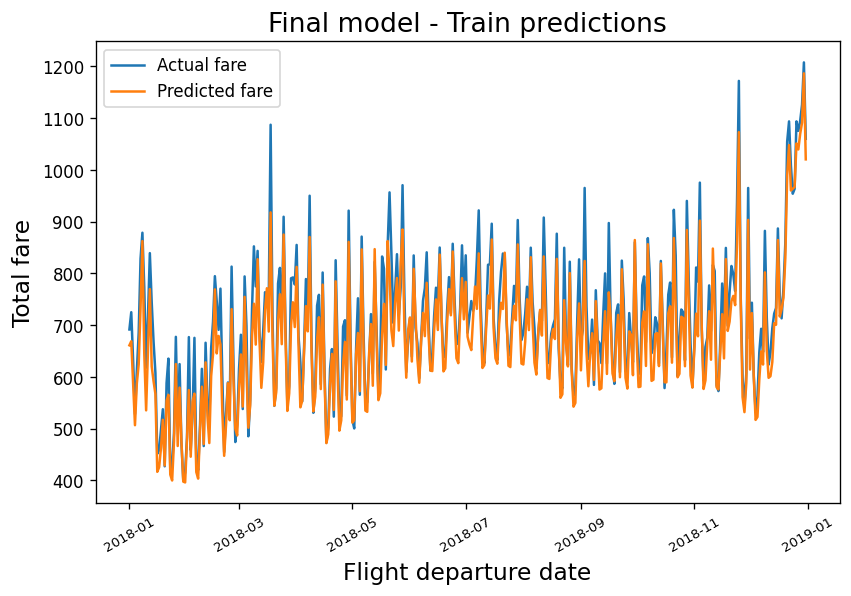

In [41]:
plt.figure(figsize = (8, 5), dpi = 120)
sns.lineplot(
    data = train_df.group_by('flt_departure_dt').agg(pl.col('total_fare').mean()), 
    x = "flt_departure_dt", 
    y = "total_fare",
    label = "Actual fare"
)

sns.lineplot(
    data = train_df.group_by('flt_departure_dt').agg(pl.col('pred_fare').mean()), 
    x = "flt_departure_dt", 
    y = "pred_fare",
    label = "Predicted fare"
)

locs, labels = plt.xticks()
plt.xticks(
    locs,
    [l.get_text() for l in labels],
    rotation = 30,
    fontsize = 8
)

plt.legend()
plt.title("Final model - Train predictions", fontsize = 16)
plt.xlabel("Flight departure date", fontsize = 14)
plt.ylabel("Total fare", fontsize = 14)
plt.show()

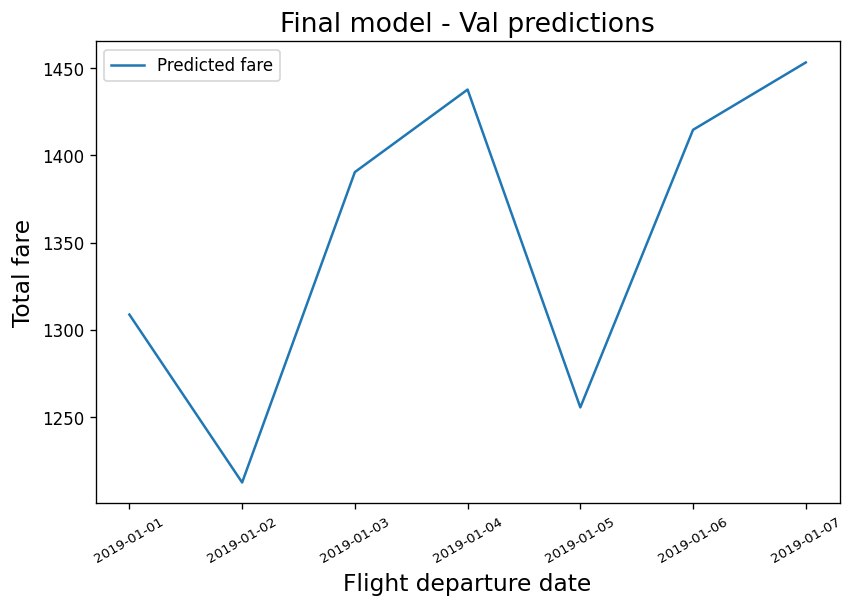

In [42]:
plt.figure(figsize = (8, 5), dpi = 120)
sns.lineplot(
    data = test_df.group_by('flt_departure_dt').agg(pl.col('pred_fare').mean()), 
    x = "flt_departure_dt", 
    y = "pred_fare",
    label = "Predicted fare"
)

locs, labels = plt.xticks()
plt.xticks(
    locs,
    [l.get_text() for l in labels],
    rotation = 30,
    fontsize = 8
)

plt.title("Final model - Val predictions", fontsize = 16)
plt.xlabel("Flight departure date", fontsize = 14)
plt.ylabel("Total fare", fontsize = 14)
plt.show()

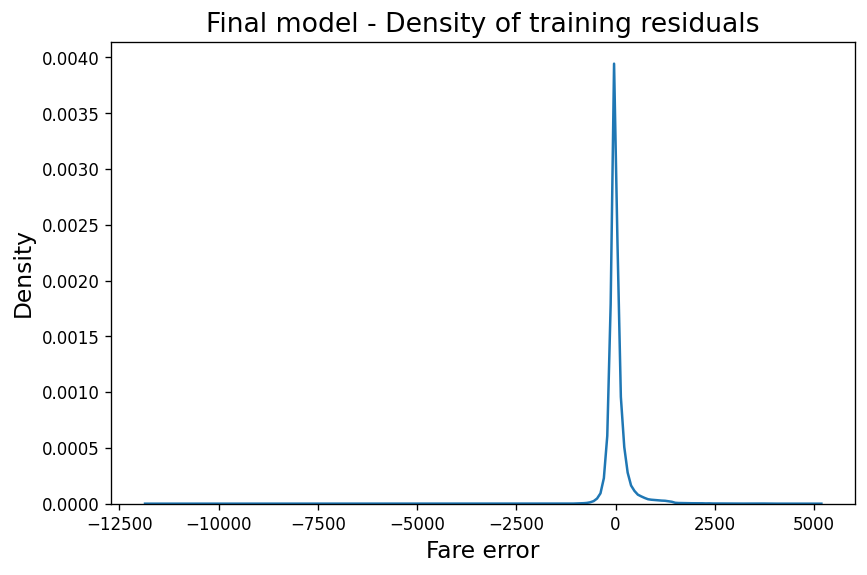

In [43]:
plt.figure(figsize = (8, 5), dpi = 120)
sns.kdeplot(
    train_df['total_fare'] - train_df['pred_fare']
)
plt.title("Final model - Density of training residuals", fontsize = 16)
plt.xlabel("Fare error", fontsize = 14)
plt.ylabel("Density", fontsize = 14)
plt.show()

### Metrics

#### Overall

In [44]:
print_metrics(
    train_df['total_fare'], train_df['pred_fare'],
    label = 'Train - GBR'
)

Train - GBR
RMSE: 295.6022
MAE: 145.7491
R2: 70.387%
Max error: 11806.1862



#### By carrier

In [45]:
for carrier, df in train_df.group_by(['carrier']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Train - Carrier {carrier[0]}'
    )

Train - Carrier L3
RMSE: 388.2959
MAE: 228.8398
R2: 34.798%
Max error: 2268.9071

Train - Carrier OTH
RMSE: 289.4343
MAE: 100.7191
R2: 89.063%
Max error: 11806.1862

Train - Carrier L2
RMSE: 271.8898
MAE: 110.6515
R2: 62.416%
Max error: 3941.7327

Train - Carrier L1
RMSE: 318.9796
MAE: 169.4159
R2: 64.130%
Max error: 5120.2629

Train - Carrier U1
RMSE: 148.2953
MAE: 90.2151
R2: 73.530%
Max error: 1393.3521

Train - Carrier U3
RMSE: 138.5277
MAE: 98.1046
R2: 54.704%
Max error: 1271.3661



#### By route

In [46]:
for route_id, df in train_df.group_by(['route_id']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Train - Route {route_id[0]}'
    )

Train - Route 0
RMSE: 293.6579
MAE: 160.2333
R2: 56.634%
Max error: 4613.4282

Train - Route 9
RMSE: 317.4968
MAE: 164.4353
R2: 63.377%
Max error: 3851.2731

Train - Route 6
RMSE: 297.4662
MAE: 126.6239
R2: 70.508%
Max error: 11806.1862

Train - Route 3
RMSE: 292.1601
MAE: 182.4077
R2: 71.598%
Max error: 3818.1051

Train - Route 4
RMSE: 317.6459
MAE: 143.2321
R2: 70.859%
Max error: 9310.3701

Train - Route 7
RMSE: 326.0290
MAE: 169.8242
R2: 51.733%
Max error: 5120.2629

Train - Route 1
RMSE: 434.0324
MAE: 227.9835
R2: 49.147%
Max error: 4492.1499

Train - Route 10
RMSE: 316.6852
MAE: 168.3132
R2: 65.100%
Max error: 3462.0134

Train - Route 11
RMSE: 207.3987
MAE: 111.9612
R2: 61.586%
Max error: 3077.9416

Train - Route 5
RMSE: 225.1576
MAE: 124.2406
R2: 66.591%
Max error: 3150.0994

Train - Route 2
RMSE: 295.9326
MAE: 187.3965
R2: 65.245%
Max error: 4080.7714

Train - Route 8
RMSE: 461.7450
MAE: 263.4391
R2: 47.834%
Max error: 4480.0917



### Feature importances

In [47]:
pl.DataFrame({
    "Feature": model['gbr'].feature_names_in_,
    "FI": (model['gbr'].feature_importances_ * 100).round(2)
}).sort("FI", descending = True)

Feature,FI
str,f64
"""remainder__days_till_flight""",29.79
"""remainder__7d_route_carrier_av…",14.39
"""remainder__14d_route_avg""",10.91
"""remainder__days_since_start""",9.13
"""remainder__7d_route_avg""",7.96
"""remainder__flt_count_dpt_24h""",5.33
"""remainder__dpt_4h_od""",4.21
"""remainder__flt_departure_weekd…",4.12
"""remainder__dur_min""",1.99


## Saving final predictions

In [48]:
test_df = test_df.join(
    airports_df,
    left_on = "origin_id",
    right_on = "airport_id",
    how = "left"
).with_columns(
    pl.col('airport').alias('origin')
).drop('airport').join(
    airports_df,
    left_on = "destination_id",
    right_on = "airport_id",
    how = "left"
).with_columns(
    pl.col('airport').alias('destination')
).drop('airport').with_columns(
    pl.col('flt_departure_dt').dt.strftime(r"%-m/%-d/%Y"),
    pl.col('observation_date').dt.strftime(r"%-m/%-d/%Y")
)

test_df

carrier,flt_num,flt_departure_dt,observation_date,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,dur_mean,pred_scaled_fare,pred_fare,origin,destination
str,i64,str,str,i16,i8,u8,datetime[ns],datetime[ns],f64,i16,i8,i8,u8,i16,i64,i64,u8,u8,u8,f64,f64,f64,f64,i64,i8,i8,i8,i8,f64,f64,f64,str,str
"""L2""",7465,"""1/1/2019""","""11/27/2018""",35,0,9,2019-01-01 08:04:00,2019-01-01 10:49:00,165.0,-360,0,2,7,2,null,null,5,6,0,2.944702,0.824263,0.877499,0.759055,365,1,1,1,2,164.36,-0.037938,680.747499,"""Airport4""","""Airport43"""
"""L2""",7067,"""1/1/2019""","""11/27/2018""",35,0,9,2019-01-01 13:17:00,2019-01-01 16:00:00,163.0,-360,0,3,7,2,null,null,5,6,0,2.944702,0.824263,0.877499,0.759055,365,1,1,1,2,164.36,-0.037958,680.654234,"""Airport4""","""Airport43"""
"""L2""",1232,"""1/1/2019""","""11/27/2018""",35,0,9,2019-01-01 18:40:00,2019-01-01 21:25:00,165.0,-360,0,4,7,2,null,null,5,6,0,2.944702,0.824263,0.877499,0.759055,365,1,1,1,2,164.36,-0.04458,650.768957,"""Airport4""","""Airport43"""
"""U3""",752,"""1/1/2019""","""11/27/2018""",35,0,7,2019-01-01 08:45:00,2019-01-01 10:07:00,82.0,-360,0,2,9,3,null,null,5,0,0,2.725651,1.384941,0.73477,1.165811,365,1,1,1,2,81.2,0.036033,666.601223,"""Airport4""","""Airport17"""
"""L1""",5135,"""1/1/2019""","""11/27/2018""",35,0,7,2019-01-01 07:25:00,2019-01-01 08:42:00,77.0,-360,0,1,9,2,null,null,5,0,0,2.863554,1.384941,0.73477,1.428838,365,1,1,1,2,74.94,-0.058605,496.29025,"""Airport4""","""Airport17"""
"""L1""",10966,"""1/1/2019""","""11/27/2018""",35,0,7,2019-01-01 11:54:00,2019-01-01 13:18:00,84.0,-360,0,2,9,3,null,null,5,0,0,2.863554,1.384941,0.73477,1.428838,365,1,1,1,2,74.94,-0.003997,711.388662,"""Airport4""","""Airport17"""
"""L1""",2181,"""1/1/2019""","""11/27/2018""",35,0,7,2019-01-01 15:34:00,2019-01-01 16:51:00,77.0,-360,0,3,9,2,null,null,5,0,0,2.863554,1.384941,0.73477,1.428838,365,1,1,1,2,74.94,-0.025961,615.479387,"""Airport4""","""Airport17"""
"""L1""",2724,"""1/1/2019""","""11/27/2018""",35,0,8,2019-01-01 06:00:00,2019-01-01 10:30:00,270.0,-360,0,1,5,2,null,null,5,1,0,3.016892,0.766536,0.587293,0.766536,365,1,1,1,2,277.95,-0.031523,835.197681,"""Airport4""","""Airport20"""
"""L3""",18075,"""1/1/2019""","""11/27/2018""",35,0,4,2019-01-01 15:10:00,2019-01-01 16:30:00,80.0,-480,0,3,32,9,null,null,3,4,0,2.7672,1.969383,1.372765,1.385398,365,1,1,1,2,78.98,-0.033621,472.241203,"""Airport30""","""Airport31"""


In [49]:
raw_test_df = raw_test_df.join(
    test_df.select(
        [
            'origin', 'destination', 'carrier',
            'flt_num', 'flt_departure_dt', 'observation_date',
            'pred_fare'
        ]
    ),
    on = [
        'origin', 'destination', 'carrier',
        'flt_num', 'flt_departure_dt', 'observation_date'
    ],
    how = "left"
).rename(
    {'pred_fare': 'predicted_fares'}
).with_columns(
    pl.col('predicted_fares').round().cast(pl.Int64())
)

raw_test_df

,origin,destination,carrier,flt_num,flt_departure_dt,observation_date,origin_city,destination_city,predicted_fares
i64,str,str,str,i64,str,str,str,str,i64
1,"""Airport4""","""Airport43""","""L2""",7465,"""1/1/2019""","""11/27/2018""","""City4""","""City39""",681
2,"""Airport4""","""Airport43""","""L2""",7067,"""1/1/2019""","""11/27/2018""","""City4""","""City39""",681
3,"""Airport4""","""Airport43""","""L2""",1232,"""1/1/2019""","""11/27/2018""","""City4""","""City39""",651
4,"""Airport43""","""Airport4""","""L1""",17783,"""1/3/2019""","""11/29/2018""","""City39""","""City4""",872
5,"""Airport43""","""Airport4""","""L1""",5823,"""1/3/2019""","""11/29/2018""","""City39""","""City4""",948
6,"""Airport43""","""Airport4""","""L1""",1763,"""1/3/2019""","""11/29/2018""","""City39""","""City4""",928
7,"""Airport4""","""Airport17""","""U3""",752,"""1/1/2019""","""11/30/2018""","""City4""","""City17""",667
8,"""Airport4""","""Airport17""","""U3""",752,"""1/2/2019""","""11/30/2018""","""City4""","""City17""",503
9,"""Airport4""","""Airport17""","""U3""",752,"""1/3/2019""","""11/30/2018""","""City4""","""City17""",597


In [50]:
raw_test_df['predicted_fares'].describe()

statistic,value
str,f64
"""count""",29825.0
"""null_count""",0.0
"""mean""",1355.162079
"""std""",2883.101406
"""min""",202.0
"""25%""",528.0
"""50%""",675.0
"""75%""",913.0
"""max""",27416.0


In [51]:
raw_test_df.write_csv(Path("..", "test_fares_data_Mayur_Garg.csv"))